# Pokemon stats

This project came about by looking around on Kaggle for machine learning exercises/projects when I found [This](https://www.kaggle.com/abcsds/pokemon) and the question posed at the end seemed interesting enough to explore -- can you identify the type of pokemon based only on two of its statistics. This project is far from finished, but I will probably update it in the future if I have new ideas or techniques.

Quickly back to the question posed, "Given two different stats of a pokemon, can you determine its type?" the answer to this question should be 'No'. To see why this is the case all we need is a little bit of linear algebra. Consider 6 linearly independent vectors, we can ask the question "How many different 2-dimensional subspaces exist?" The answer to this question is simply 6 choose 2, which gives 15. If you are rusty on your linear algebra the thing to remember is that span(x,y) = span(y,x). While 15 is a large number, as we will see below, there are 18 different types of pokemon. One might quickly point out that our pokemon set has 7 statistics, but we should remember that the 'Total' statistic is merely the sum of the other 6.

But we will see what we can do. First we will look at the simpler question of "Can you correctly identify a legendary pokemon or not given its total stats?" Then we will look at the similar "Is this pokemon Grass or not Grass?", for example, for all the different types.

And away we go!

In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.naive_bayes import GaussianNB


from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

import graphviz


#index false to deal with pokemon with the same '#'
df = pd.read_csv('Pokemon.csv', index_col =False)
df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


In [2]:
df.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

There are a couple of things to note here, the first one is that there are 721 pokemon but 800 rows. We can easily deal with these problems directly and just combine all the rows together that have the same entry in the '#' column. It is worth mentioning what is going on in each. Pokemon with the tag 'Mega' (VenusaurMega Venusaur for example) in their name were introduced as a mechanic in generation 6, they are not catchable and only appear in battle, so including them in the set seems off. Similarly we have pokemon that have different sizes, but the same stats (Gourgeist average, small, large, super). Finally there are pokemon with the same number, different stats due to 'formes' (Hoopa and Deoxys below).

It is worth taking into account the pokemon that have the same number and different stats as affecting our model, but we will just work with whatever one appears in the list first.

In [3]:
df_no = df[df.Name.str.contains("Mega")== False]

In [4]:
# Pokemon with the same number but different stats, non-mega form. 
# Also note Hoopa Confined and Unbound above for different stats.
df_no[386:390]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
428,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
429,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
430,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
431,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True


In [5]:
#this kills some data but can also be used to remove the mega evolved pokemon
df_dup = df_no.drop_duplicates('#')

We will start our hunt to identify legendary pokemon based on one stat. Before getting to the analysis, we should discuss why this seems reasonable. Maybe it comes from having played a few of the games in the past, or maybe it is because these pokemon are described as 'Legendary', but something about them should stand out. While we have no real way of determining how they stand out exactly, maybe the pokemon has legendary speed or strength, it should be detected in the 'Total' column.

Note that the Deoxys above is legendary has total stats 600, while the first table at the start calls many non legendary pokemon with stats far less than 600.

In [6]:
#Getting Legendary and the stats
df_fin =df_dup.drop(['Name', '#','Type 1','Type 2', 'Generation'], axis = 1)

In [7]:
labelencoder=LabelEncoder()
for column in df_fin.columns:
    df_fin[column] = labelencoder.fit_transform(df_fin[column])

In [8]:
df_fin.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,103.451389,38.000000,48.447222,41.859722,42.611111,38.587500,42.973611,0.063889
std,51.899366,20.198321,24.671133,21.927204,23.794470,21.182776,24.302981,0.244725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,21.000000,28.750000,24.000000,22.000000,22.000000,24.000000,0.000000
50%,103.500000,36.000000,49.500000,39.000000,41.000000,37.000000,42.000000,0.000000
75%,150.250000,51.000000,69.000000,57.000000,62.000000,54.000000,62.000000,0.000000
max,182.000000,93.000000,99.000000,96.000000,93.000000,89.000000,100.000000,1.000000


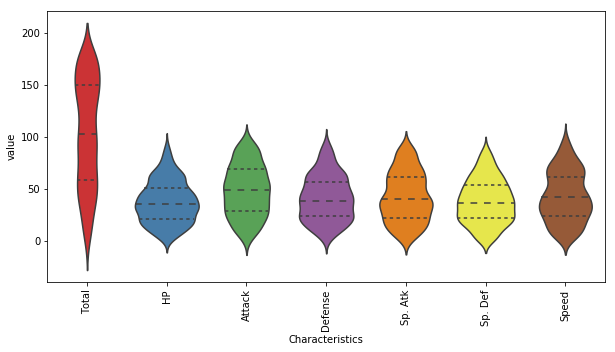

In [9]:
df_div = pd.melt(df_fin, "Legendary", var_name="Characteristics")
fig, ax = plt.subplots(figsize=(10,5))
p = sns.violinplot(ax = ax, x="Characteristics", y="value", split = True, data=df_div, inner = 'quartile', palette = 'Set1')
df_no_class = df.drop(["Legendary"],axis = 1)
p.set_xticklabels(rotation = 90, labels = list(df_fin.columns));

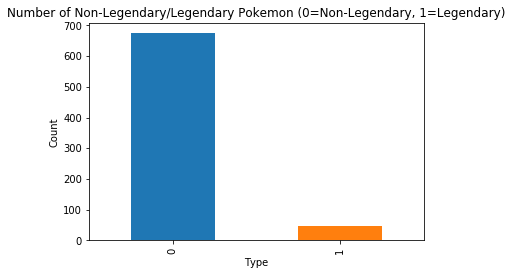

In [10]:
plt.figure()
pd.Series(df_fin['Legendary']).value_counts().sort_index().plot(kind = 'bar')
plt.ylabel("Count")
plt.xlabel("Type")
plt.title('Number of Non-Legendary/Legendary Pokemon (0=Non-Legendary, 1=Legendary)');

As can be seen here, there are few legendary pokemon on our set, so just guessing 'No that pokemon is not legendary' will be right most of the time. So our model better be good.

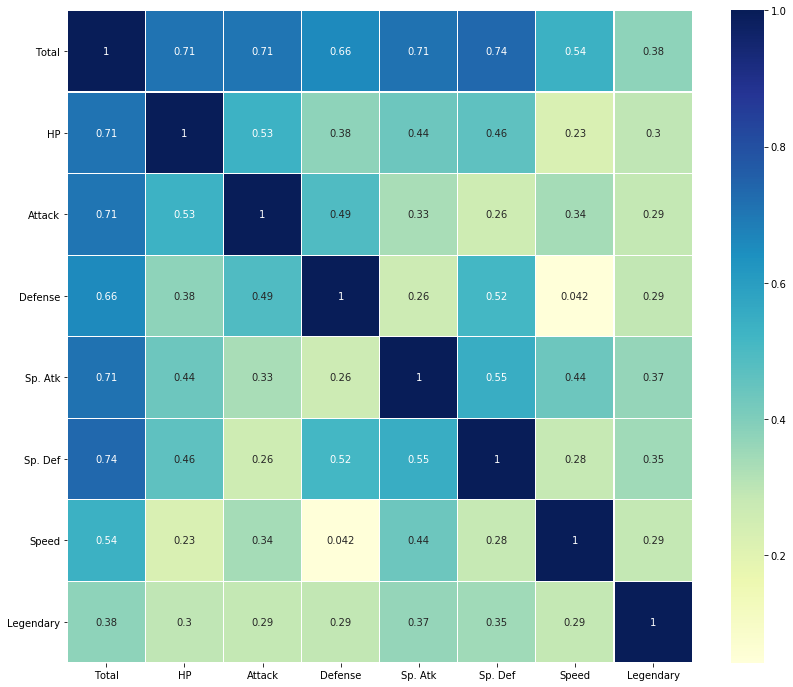

In [11]:
plt.figure(figsize=(14,12))
sns.heatmap(df_fin.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

As seen in the correlation matrix above, 'Total' is the highest among the stats when related to 'Legendary' status.

In [12]:
# new_var=df_fin[['Legendary', 'Total']]
# new_var=new_var[new_var['Total']<=170]
# sns.factorplot('Legendary', col='Total', data=new_var, kind='count', size=2.5, aspect=.8, col_wrap=4);

In [13]:
# new_var=df_fin[['Legendary', 'Total']]
# new_var=new_var[new_var['Total']>170]

# sns.factorplot('Legendary', col='Total', data=new_var, kind='count', size=2.5, aspect=.8, col_wrap=4);

Now we make our model!

In [14]:
X=df_fin.drop(['Legendary'], axis=1)
Y=df_fin['Legendary']

In [15]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.1)

In [16]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

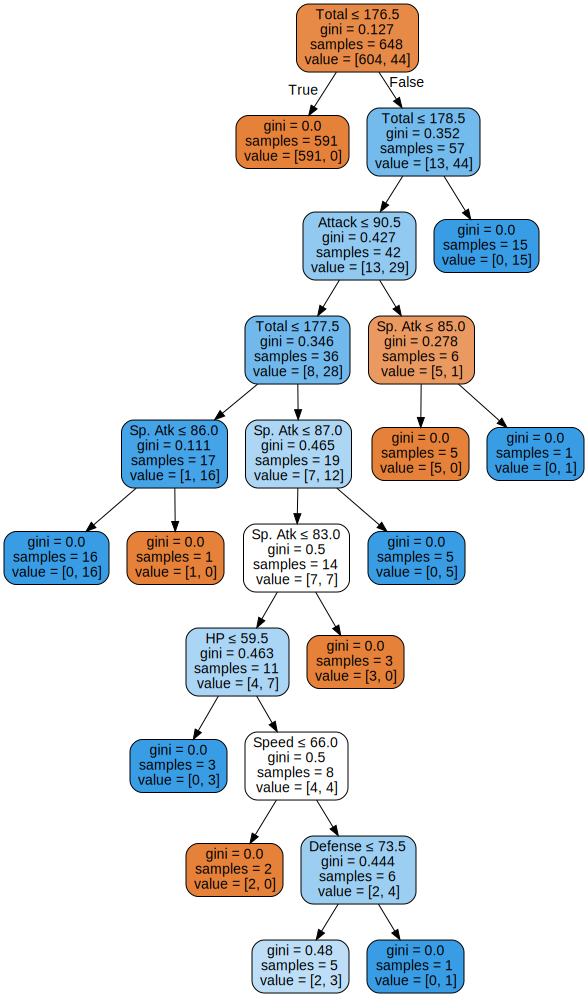

In [17]:
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

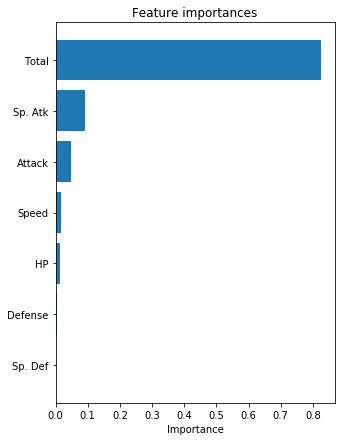

In [18]:
features_list = X.columns.values
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [19]:
y_pred=clf.predict(X_test)

In [20]:
print("Decision Tree Classifier report \n", classification_report(Y_test, y_pred))

Decision Tree Classifier report 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.50      1.00      0.67         2

   micro avg       0.97      0.97      0.97        72
   macro avg       0.75      0.99      0.83        72
weighted avg       0.99      0.97      0.98        72



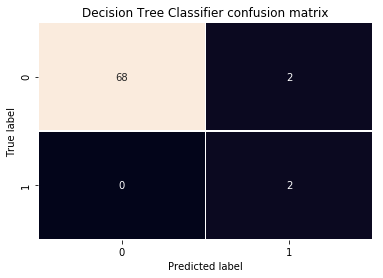

In [21]:
cfm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cfm, annot = True,  linewidths=.5, cbar =None)
plt.title('Decision Tree Classifier confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [22]:
clf_GNB = GaussianNB()
clf_GNB = clf_GNB.fit(X_train, Y_train)

In [23]:
y_pred_GNB=clf_GNB.predict(X_test)

In [24]:
cfm=confusion_matrix(Y_test, y_pred_GNB)

Text(0.5, 15.0, 'Predicted label')

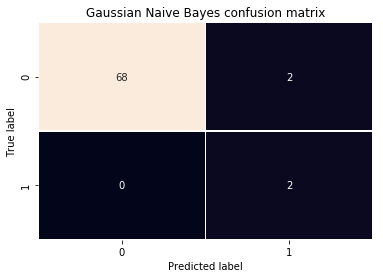

In [25]:
sns.heatmap(cfm, annot = True,  linewidths=.5, cbar =None)
plt.title('Gaussian Naive Bayes confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [26]:
print("Test data- Gaussian Naive Bayes report \n", classification_report(Y_test, y_pred_GNB))

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.50      1.00      0.67         2

   micro avg       0.97      0.97      0.97        72
   macro avg       0.75      0.99      0.83        72
weighted avg       0.99      0.97      0.98        72



# To grass or not to grass

Here we try the above but where we replace the boolean 'Legendary' with the boolean 'Grass'. This probably won't work as well as there is no stat that immediately jumps out, eg. "Why should grass pokemon be fast/strong/high health".

In [27]:
df_fin2 = df_dup.drop(['Name', '#','Type 2', 'Generation', 'Legendary'], axis = 1)

In [28]:
df_fin2.head()

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Grass,318,45,49,49,65,65,45
1,Grass,405,60,62,63,80,80,60
2,Grass,525,80,82,83,100,100,80
4,Fire,309,39,52,43,60,50,65
5,Fire,405,58,64,58,80,65,80


We are going to do all the Types at once with for loops! I am pretty sure this is the part that throws off the download as .tex, so the graphs might be missing should I make this a pdf.

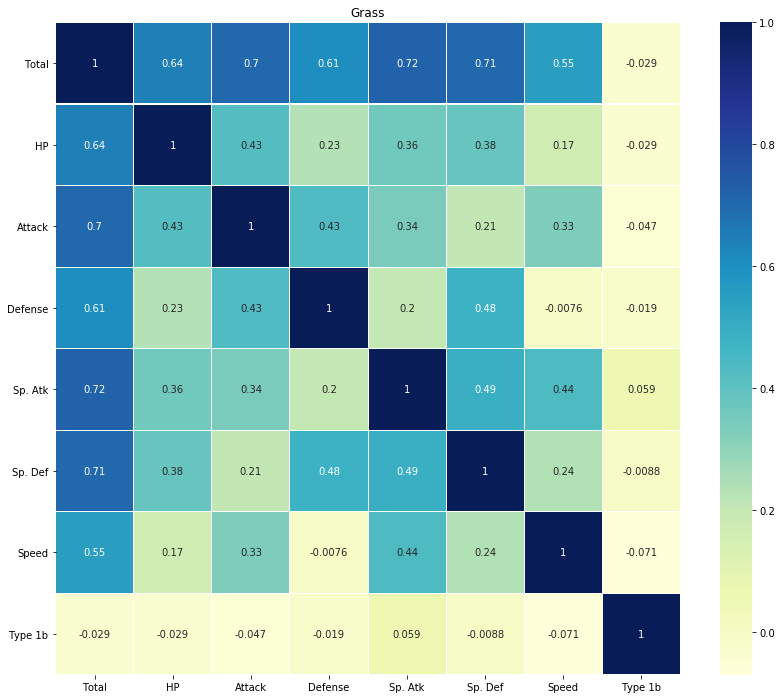

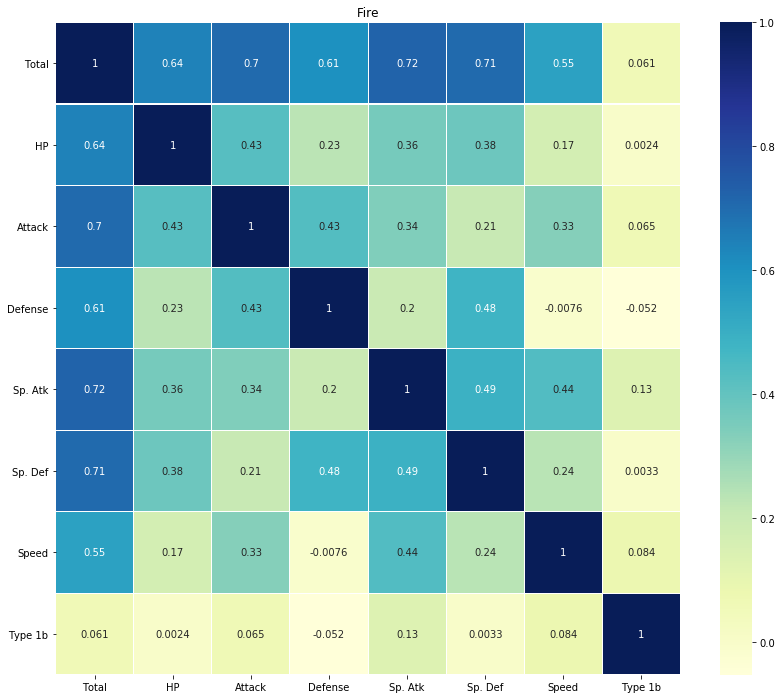

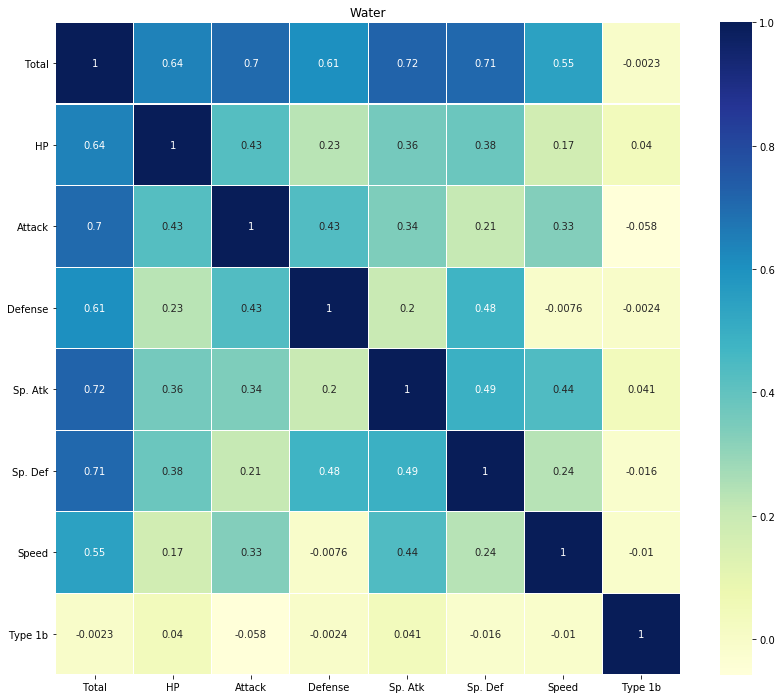

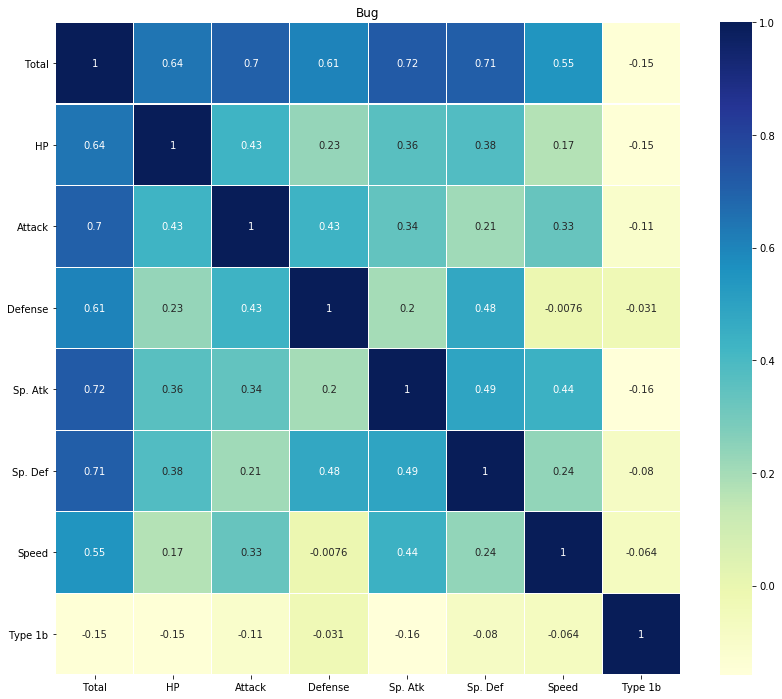

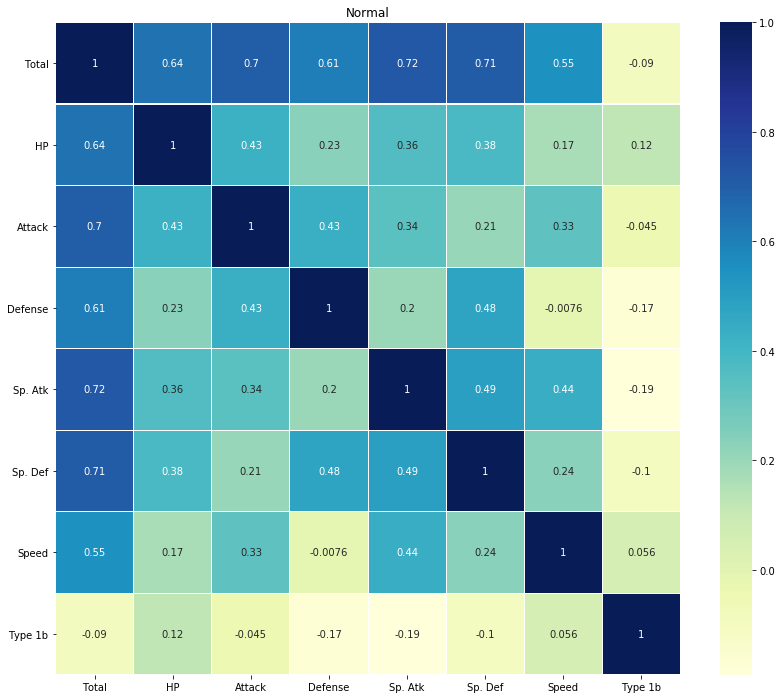

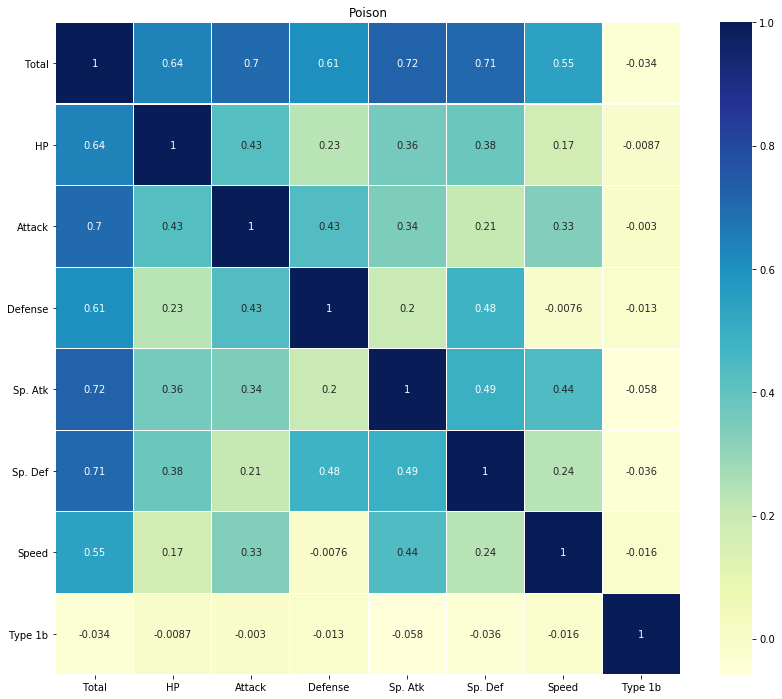

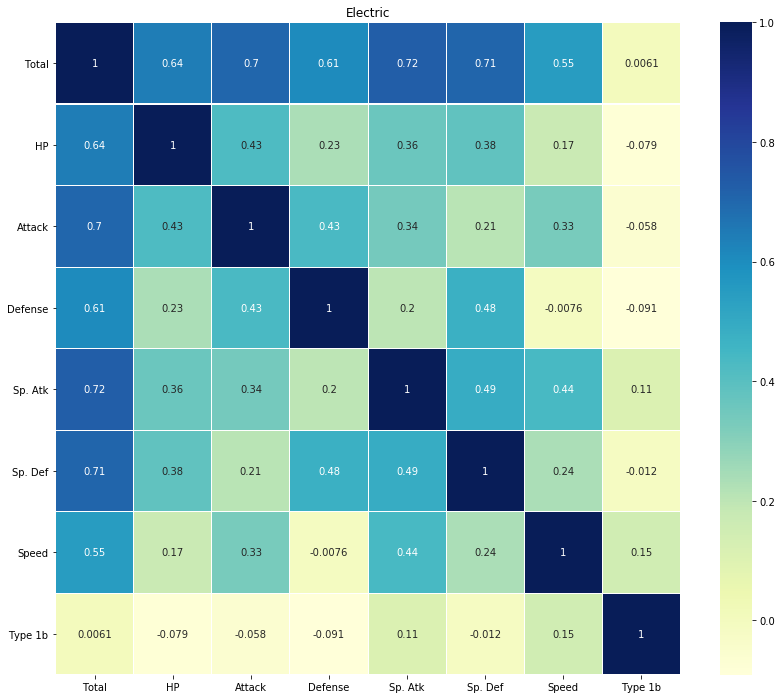

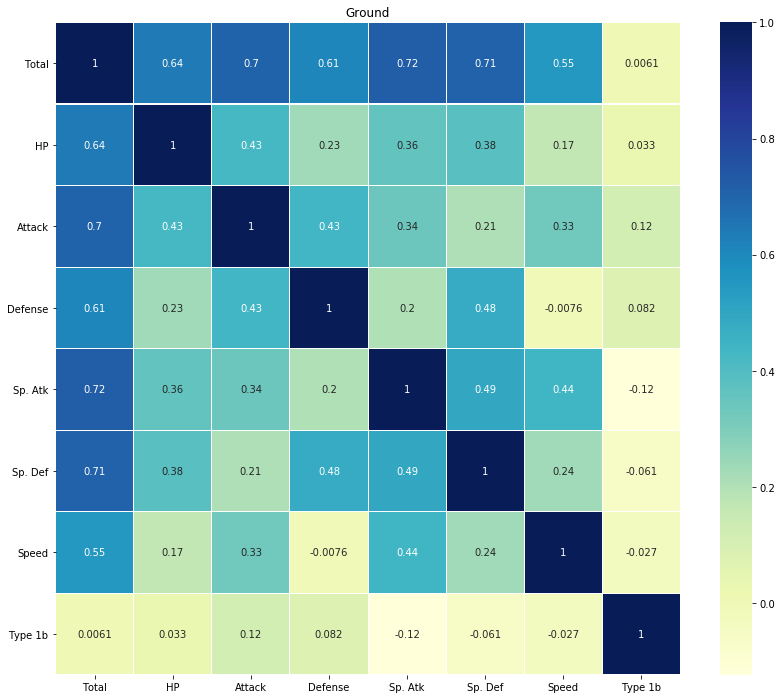

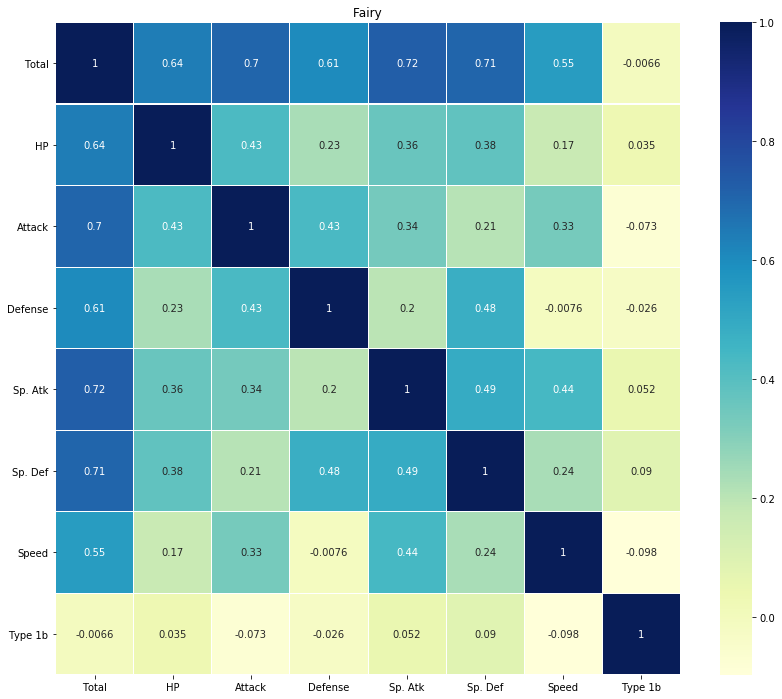

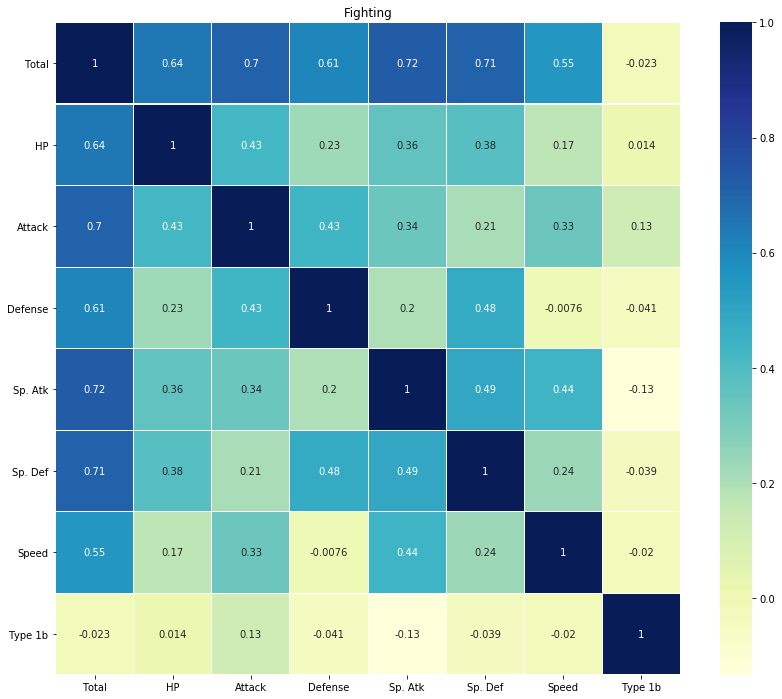

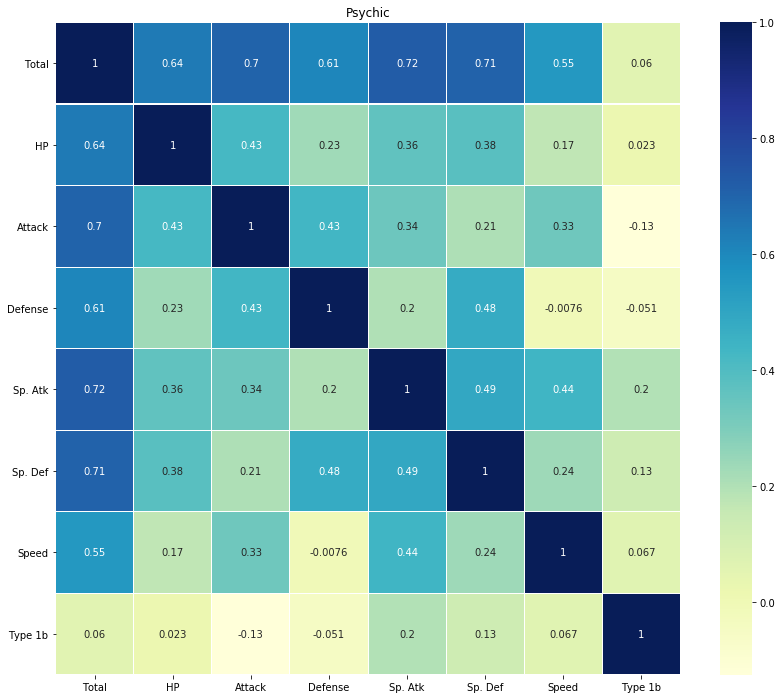

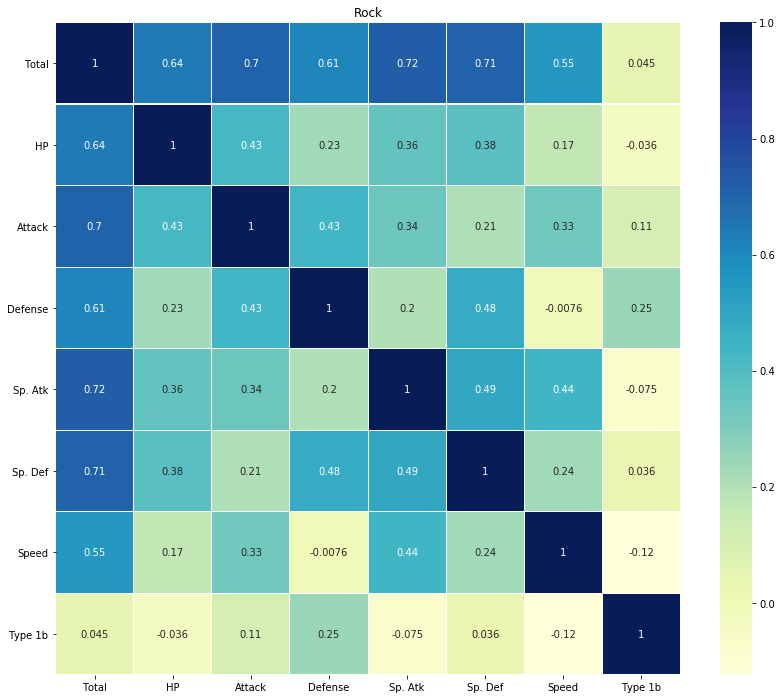

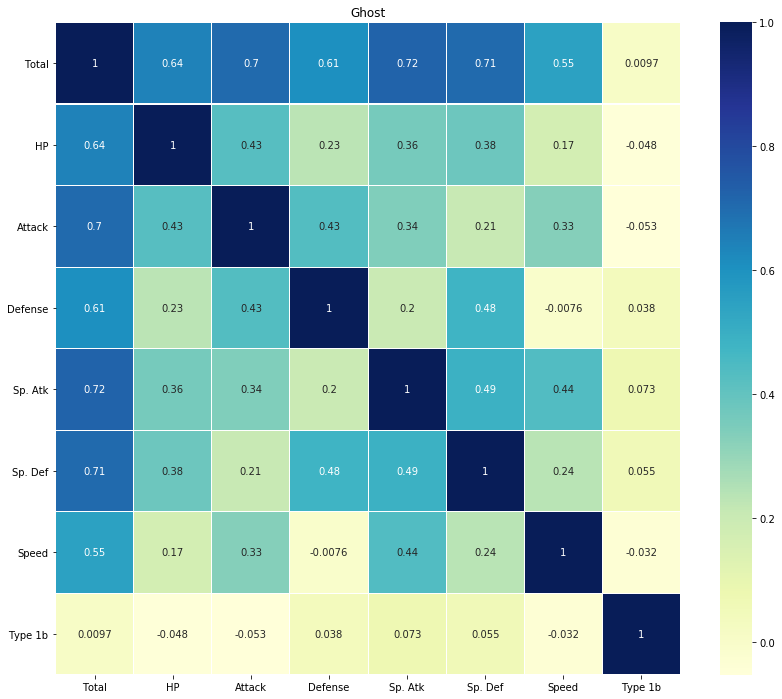

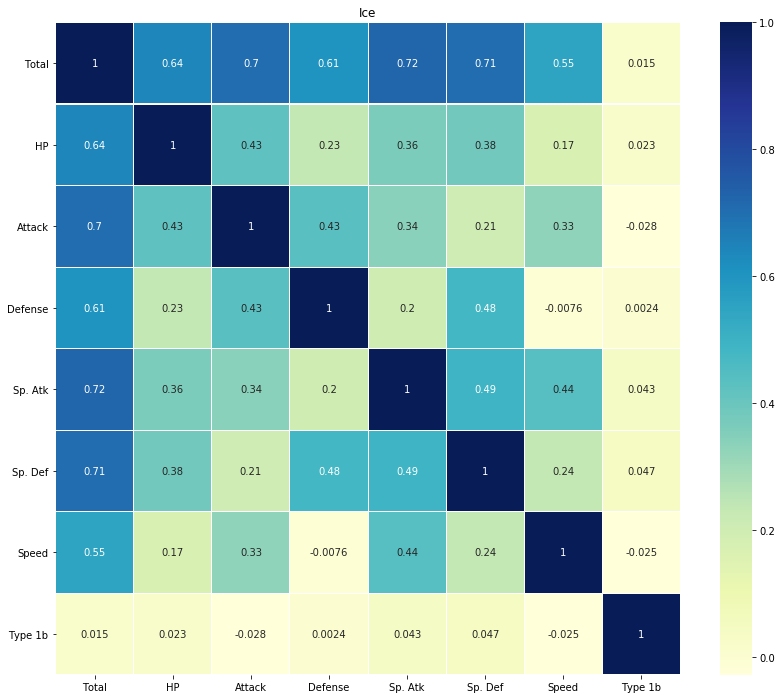

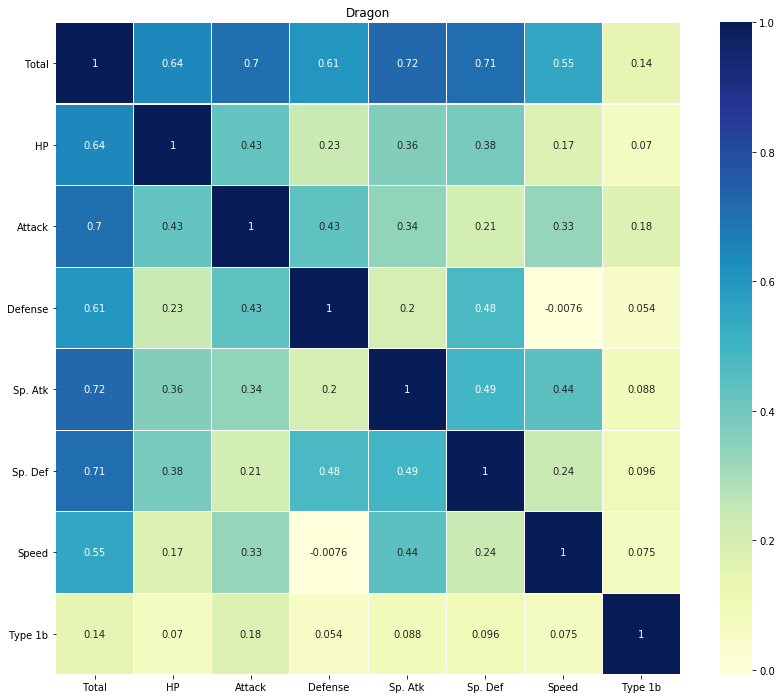

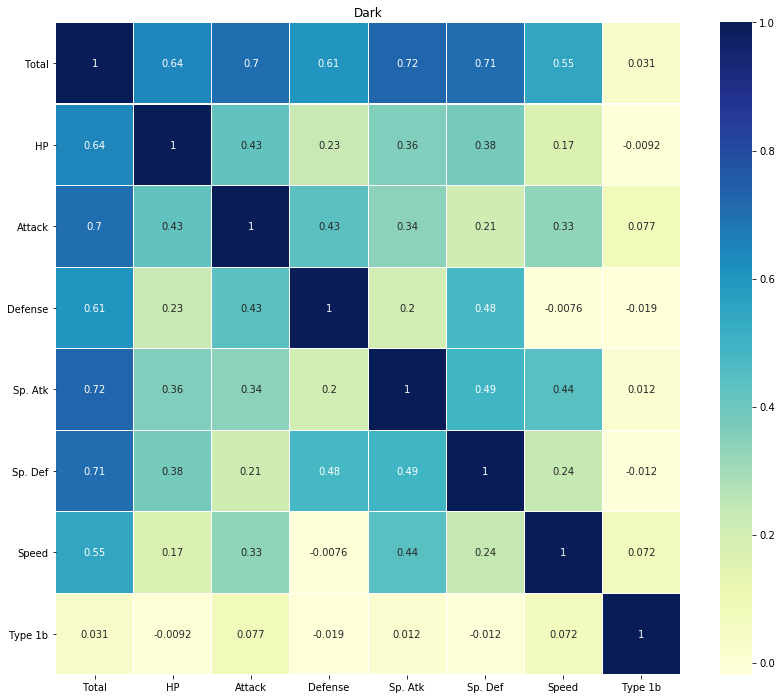

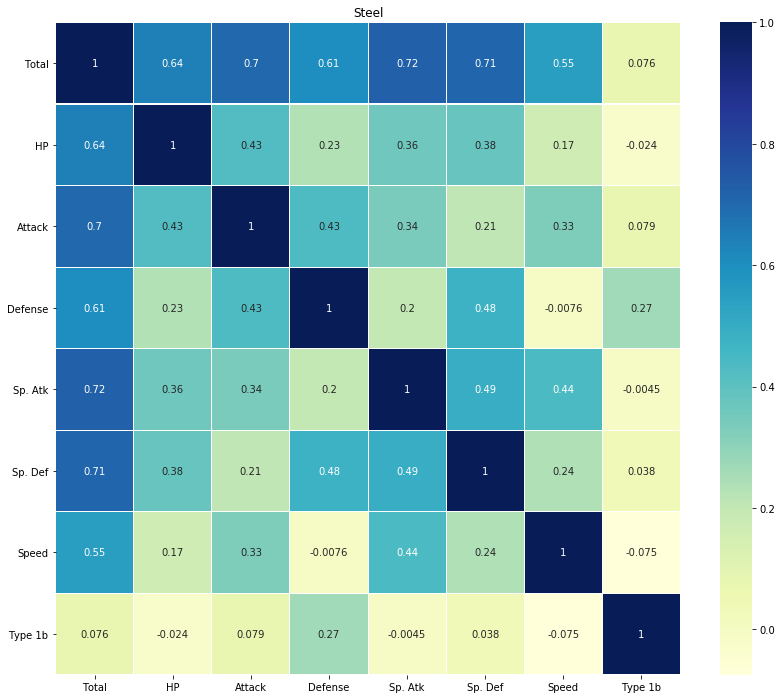

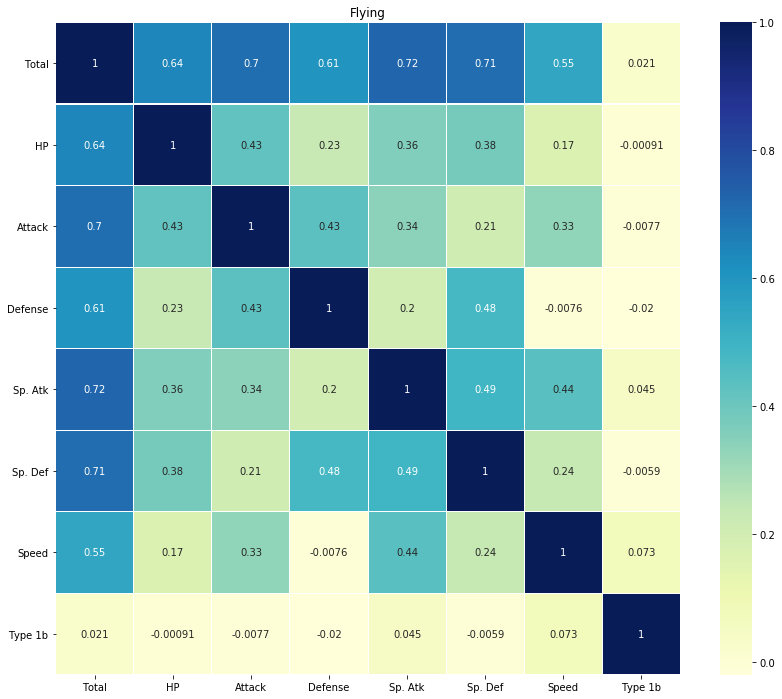

In [29]:
unique_list = list(df_fin2['Type 1'].unique())


for item in unique_list:
    
    df_fin2['Type 1b'] = (df_fin2['Type 1'] == item).astype(bool)
    plt.figure(figsize=(14,12))
    sns.heatmap(df_fin2.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
    plt.title(item)
    plt.yticks(rotation=0);

As expected, no stat really correlates to the new column 'Type 1b' -- the b stands for boolean.

In [30]:
for item in unique_list:
#     plt.figure()
#     pd.Series(df_fin2['Type 1'] == item).value_counts().sort_index().plot(kind = 'bar')
#     plt.ylabel("Count")
#     plt.xlabel("Type")
#     plt.title(item)
    print(item)
    print(len(df_fin2[df_fin2['Type 1'] == item]));

Grass
65
Fire
47
Water
105
Bug
63
Normal
93
Poison
28
Electric
36
Ground
30
Fairy
17
Fighting
25
Psychic
47
Rock
41
Ghost
23
Ice
23
Dragon
24
Dark
28
Steel
22
Flying
3


The only thing surprising from this list, is that there are only 3 pokemon with primary type (Type 1) being flying. There are plenty of birds/bats/butterflys in the game, but they have 'Flying' as their Type 2.

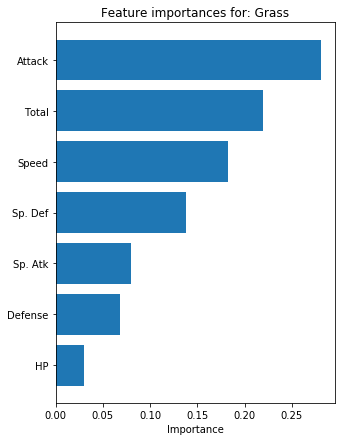

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.93      0.88      0.90       200
        True       0.07      0.12      0.09        16

   micro avg       0.82      0.82      0.82       216
   macro avg       0.50      0.50      0.50       216
weighted avg       0.86      0.82      0.84       216



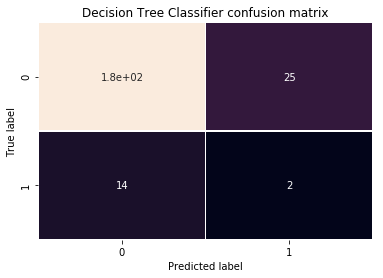

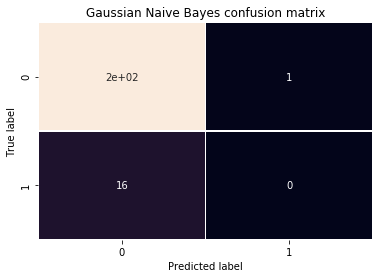

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.93      0.99      0.96       200
        True       0.00      0.00      0.00        16

   micro avg       0.92      0.92      0.92       216
   macro avg       0.46      0.50      0.48       216
weighted avg       0.86      0.92      0.89       216



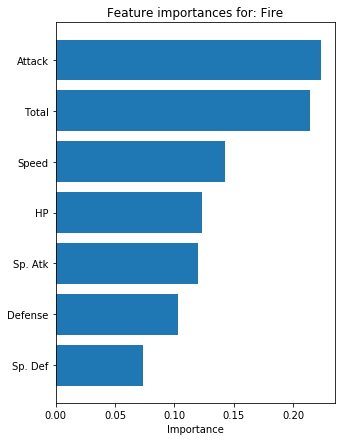

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.93      0.93      0.93       201
        True       0.07      0.07      0.07        15

   micro avg       0.87      0.87      0.87       216
   macro avg       0.50      0.50      0.50       216
weighted avg       0.87      0.87      0.87       216



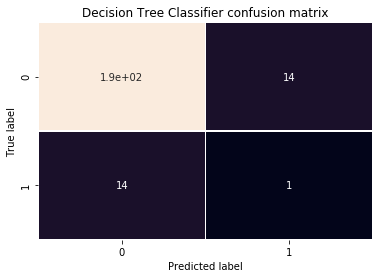

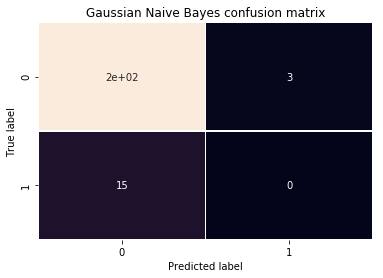

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.93      0.99      0.96       201
        True       0.00      0.00      0.00        15

   micro avg       0.92      0.92      0.92       216
   macro avg       0.46      0.49      0.48       216
weighted avg       0.87      0.92      0.89       216



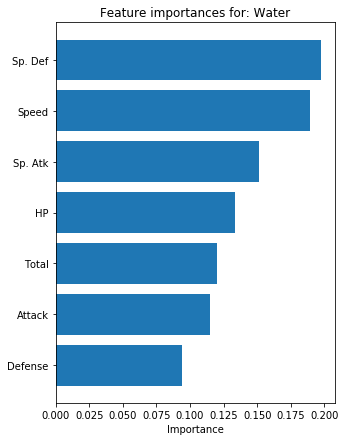

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.83      0.79      0.81       184
        True       0.07      0.09      0.08        32

   micro avg       0.69      0.69      0.69       216
   macro avg       0.45      0.44      0.45       216
weighted avg       0.72      0.69      0.71       216



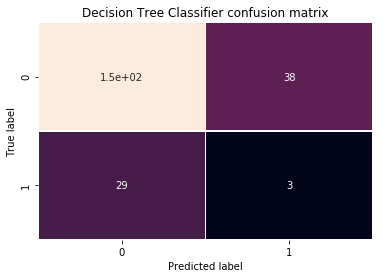

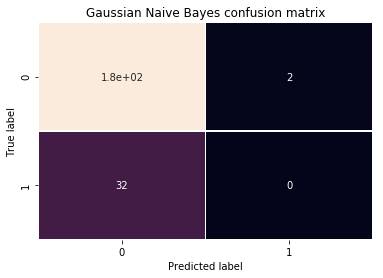

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.85      0.99      0.91       184
        True       0.00      0.00      0.00        32

   micro avg       0.84      0.84      0.84       216
   macro avg       0.43      0.49      0.46       216
weighted avg       0.72      0.84      0.78       216



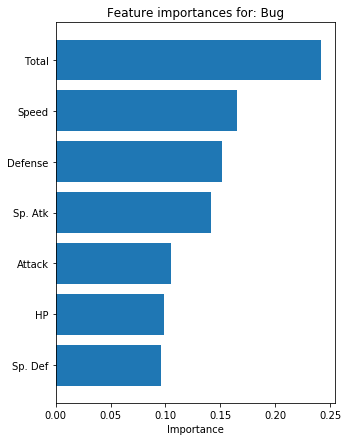

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.93      0.93      0.93       200
        True       0.18      0.19      0.18        16

   micro avg       0.88      0.88      0.88       216
   macro avg       0.56      0.56      0.56       216
weighted avg       0.88      0.88      0.88       216



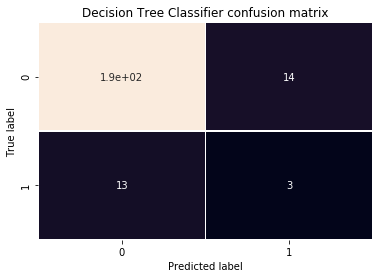

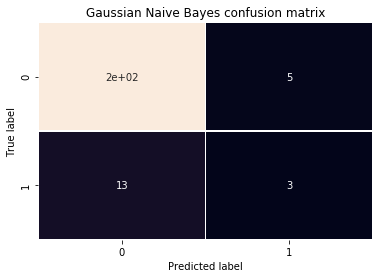

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.94      0.97      0.96       200
        True       0.38      0.19      0.25        16

   micro avg       0.92      0.92      0.92       216
   macro avg       0.66      0.58      0.60       216
weighted avg       0.90      0.92      0.90       216



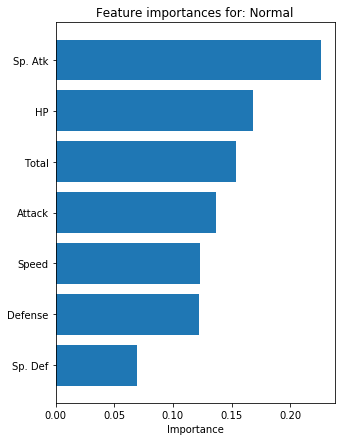

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.88      0.89      0.89       183
        True       0.35      0.33      0.34        33

   micro avg       0.81      0.81      0.81       216
   macro avg       0.62      0.61      0.61       216
weighted avg       0.80      0.81      0.80       216



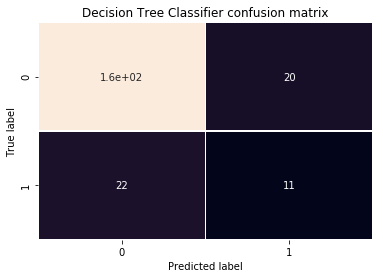

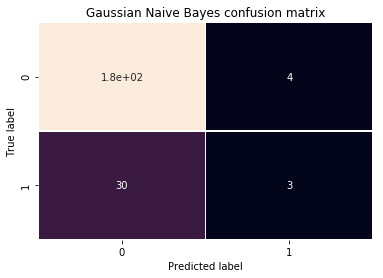

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.86      0.98      0.91       183
        True       0.43      0.09      0.15        33

   micro avg       0.84      0.84      0.84       216
   macro avg       0.64      0.53      0.53       216
weighted avg       0.79      0.84      0.80       216



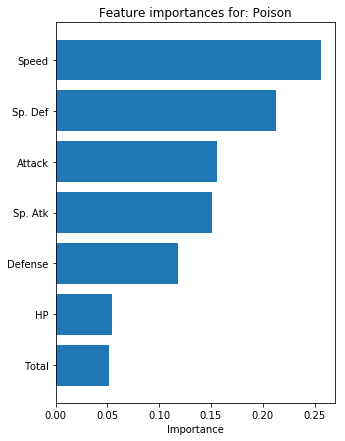

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.97      0.93      0.95       209
        True       0.00      0.00      0.00         7

   micro avg       0.90      0.90      0.90       216
   macro avg       0.48      0.47      0.47       216
weighted avg       0.93      0.90      0.92       216



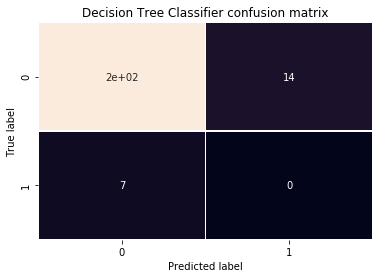

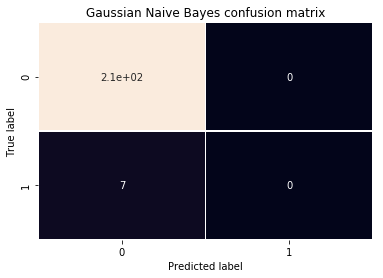

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.97      1.00      0.98       209
        True       0.00      0.00      0.00         7

   micro avg       0.97      0.97      0.97       216
   macro avg       0.48      0.50      0.49       216
weighted avg       0.94      0.97      0.95       216



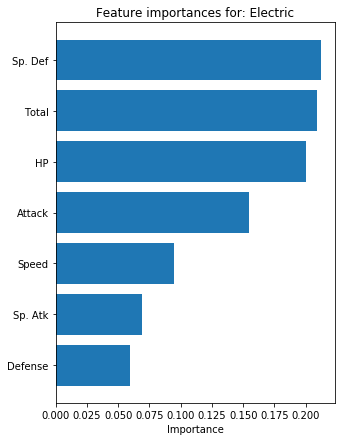

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.97      0.95      0.96       209
        True       0.08      0.14      0.11         7

   micro avg       0.92      0.92      0.92       216
   macro avg       0.53      0.55      0.53       216
weighted avg       0.94      0.92      0.93       216



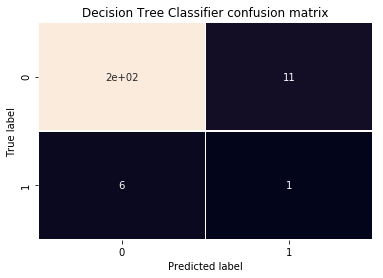

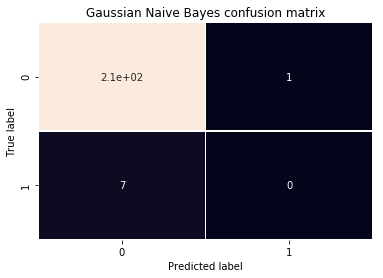

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.97      1.00      0.98       209
        True       0.00      0.00      0.00         7

   micro avg       0.96      0.96      0.96       216
   macro avg       0.48      0.50      0.49       216
weighted avg       0.94      0.96      0.95       216



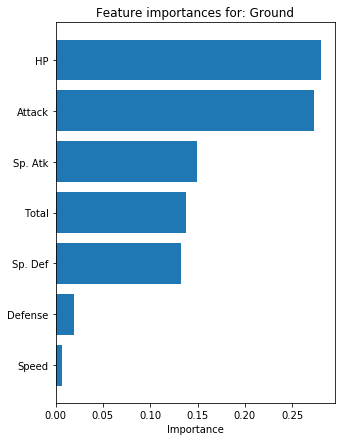

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.96      0.94      0.95       207
        True       0.00      0.00      0.00         9

   micro avg       0.90      0.90      0.90       216
   macro avg       0.48      0.47      0.47       216
weighted avg       0.92      0.90      0.91       216



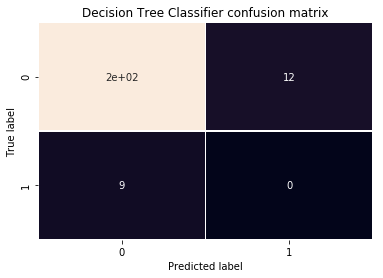

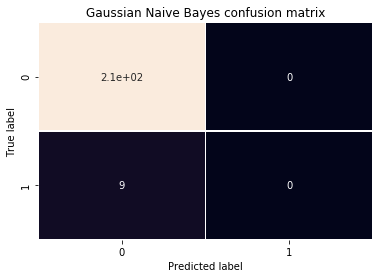

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.96      1.00      0.98       207
        True       0.00      0.00      0.00         9

   micro avg       0.96      0.96      0.96       216
   macro avg       0.48      0.50      0.49       216
weighted avg       0.92      0.96      0.94       216



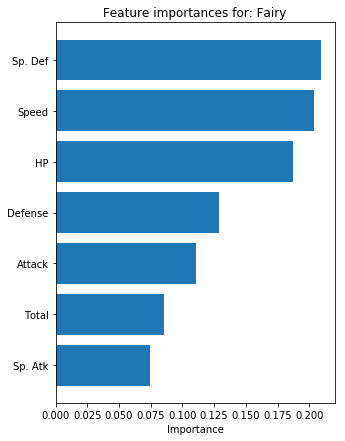

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.98      0.97      0.98       211
        True       0.14      0.20      0.17         5

   micro avg       0.95      0.95      0.95       216
   macro avg       0.56      0.59      0.57       216
weighted avg       0.96      0.95      0.96       216



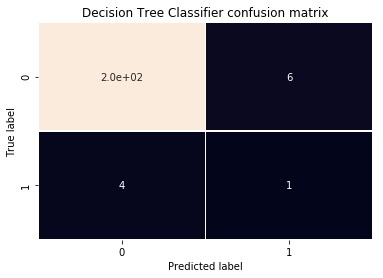

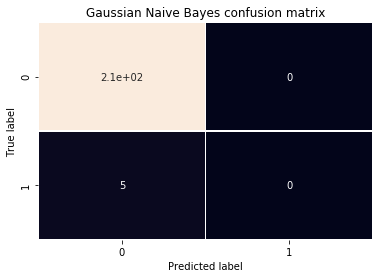

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.98      1.00      0.99       211
        True       0.00      0.00      0.00         5

   micro avg       0.98      0.98      0.98       216
   macro avg       0.49      0.50      0.49       216
weighted avg       0.95      0.98      0.97       216



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



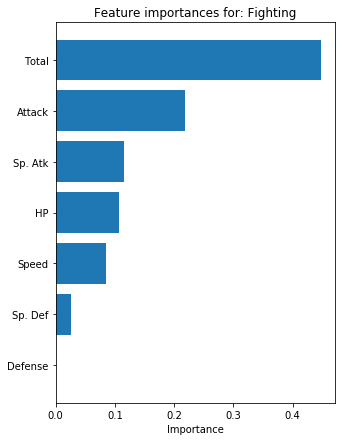

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.98      0.96      0.97       209
        True       0.18      0.29      0.22         7

   micro avg       0.94      0.94      0.94       216
   macro avg       0.58      0.62      0.59       216
weighted avg       0.95      0.94      0.94       216



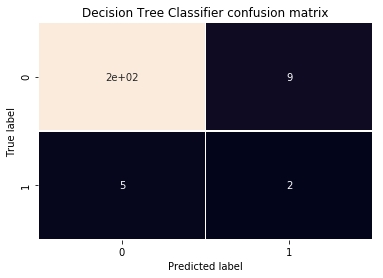

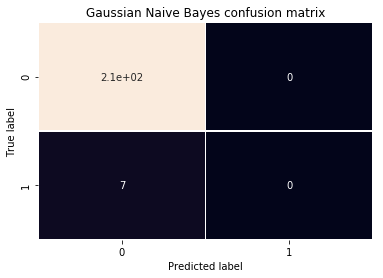

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.97      1.00      0.98       209
        True       0.00      0.00      0.00         7

   micro avg       0.97      0.97      0.97       216
   macro avg       0.48      0.50      0.49       216
weighted avg       0.94      0.97      0.95       216



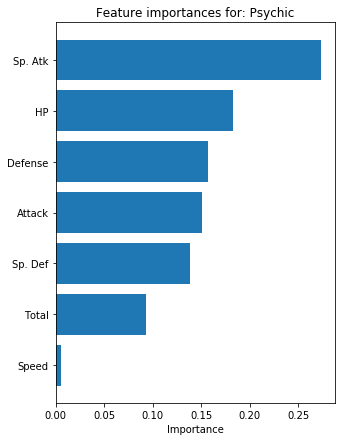

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.95      0.95      0.95       202
        True       0.21      0.21      0.21        14

   micro avg       0.90      0.90      0.90       216
   macro avg       0.58      0.58      0.58       216
weighted avg       0.90      0.90      0.90       216



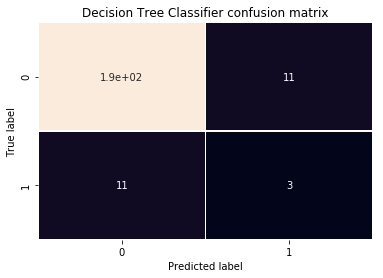

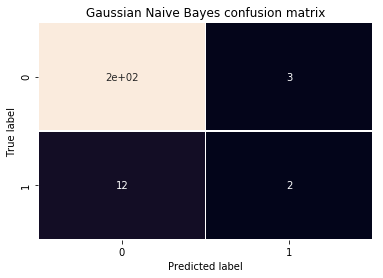

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.94      0.99      0.96       202
        True       0.40      0.14      0.21        14

   micro avg       0.93      0.93      0.93       216
   macro avg       0.67      0.56      0.59       216
weighted avg       0.91      0.93      0.91       216



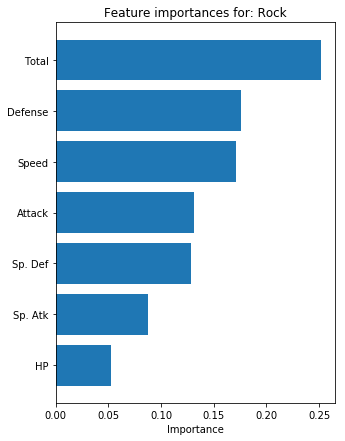

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.95      0.94      0.95       203
        True       0.20      0.23      0.21        13

   micro avg       0.90      0.90      0.90       216
   macro avg       0.58      0.59      0.58       216
weighted avg       0.91      0.90      0.90       216



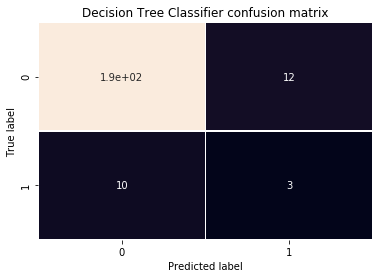

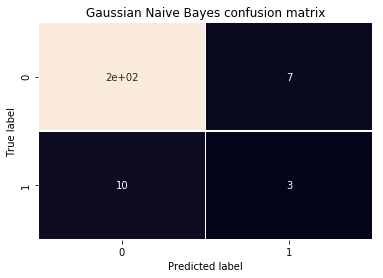

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.95      0.97      0.96       203
        True       0.30      0.23      0.26        13

   micro avg       0.92      0.92      0.92       216
   macro avg       0.63      0.60      0.61       216
weighted avg       0.91      0.92      0.92       216



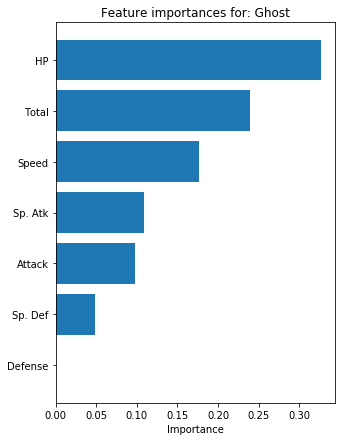

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.98      0.96      0.97       210
        True       0.11      0.17      0.13         6

   micro avg       0.94      0.94      0.94       216
   macro avg       0.54      0.56      0.55       216
weighted avg       0.95      0.94      0.95       216



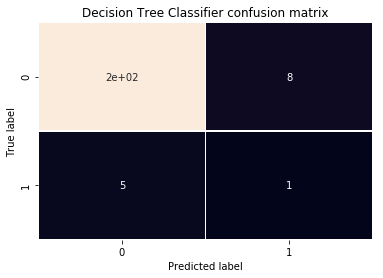

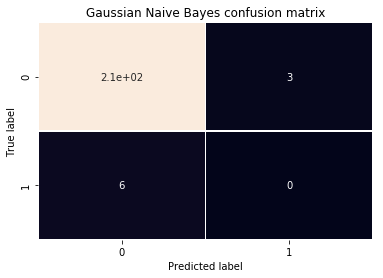

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.97      0.99      0.98       210
        True       0.00      0.00      0.00         6

   micro avg       0.96      0.96      0.96       216
   macro avg       0.49      0.49      0.49       216
weighted avg       0.94      0.96      0.95       216



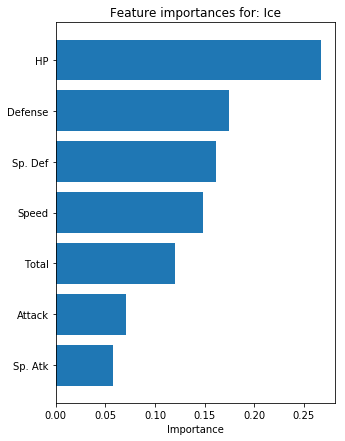

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.96      0.99      0.97       208
        True       0.00      0.00      0.00         8

   micro avg       0.95      0.95      0.95       216
   macro avg       0.48      0.49      0.49       216
weighted avg       0.93      0.95      0.94       216



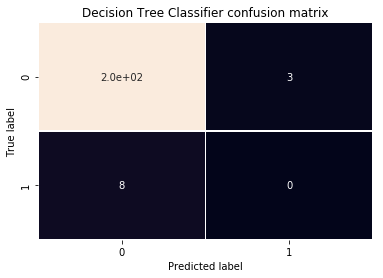

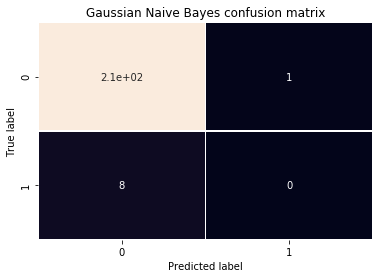

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.96      1.00      0.98       208
        True       0.00      0.00      0.00         8

   micro avg       0.96      0.96      0.96       216
   macro avg       0.48      0.50      0.49       216
weighted avg       0.93      0.96      0.94       216



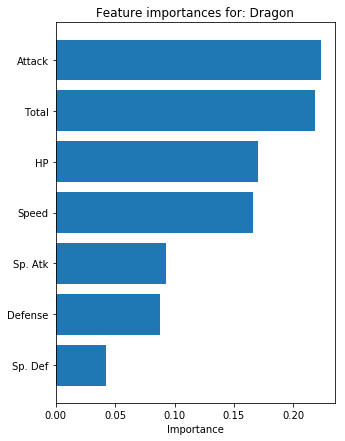

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.98      0.94      0.96       212
        True       0.00      0.00      0.00         4

   micro avg       0.92      0.92      0.92       216
   macro avg       0.49      0.47      0.48       216
weighted avg       0.96      0.92      0.94       216



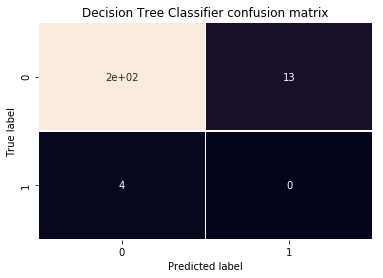

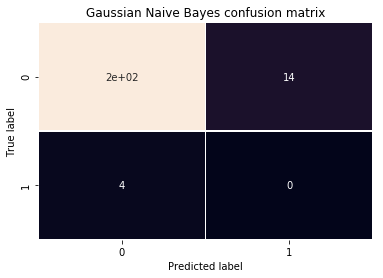

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.98      0.93      0.96       212
        True       0.00      0.00      0.00         4

   micro avg       0.92      0.92      0.92       216
   macro avg       0.49      0.47      0.48       216
weighted avg       0.96      0.92      0.94       216



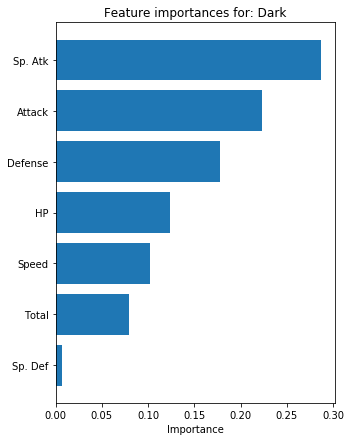

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.95      0.98      0.96       205
        True       0.00      0.00      0.00        11

   micro avg       0.93      0.93      0.93       216
   macro avg       0.47      0.49      0.48       216
weighted avg       0.90      0.93      0.91       216



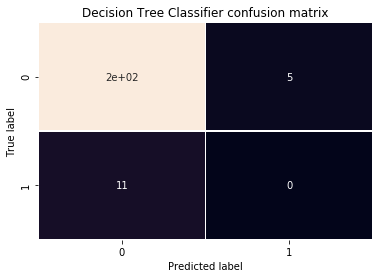

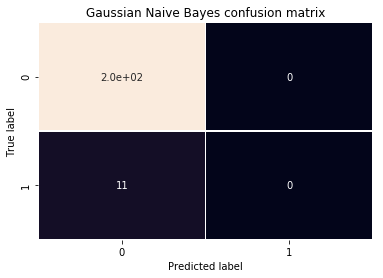

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.95      1.00      0.97       205
        True       0.00      0.00      0.00        11

   micro avg       0.95      0.95      0.95       216
   macro avg       0.47      0.50      0.49       216
weighted avg       0.90      0.95      0.92       216



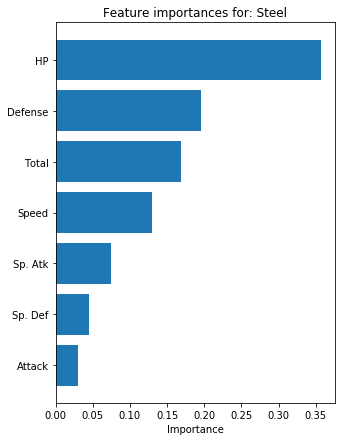

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       0.98      0.99      0.98       210
        True       0.33      0.17      0.22         6

   micro avg       0.97      0.97      0.97       216
   macro avg       0.65      0.58      0.60       216
weighted avg       0.96      0.97      0.96       216



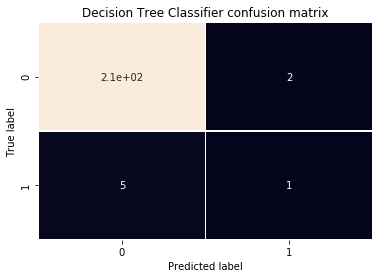

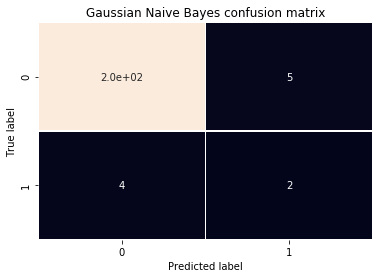

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98       210
        True       0.29      0.33      0.31         6

   micro avg       0.96      0.96      0.96       216
   macro avg       0.63      0.65      0.64       216
weighted avg       0.96      0.96      0.96       216



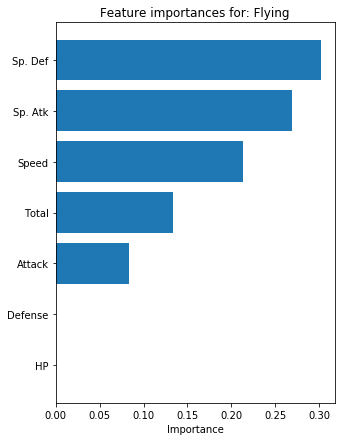

Decision Tree Classifier report 
               precision    recall  f1-score   support

       False       1.00      0.99      0.99       216
        True       0.00      0.00      0.00         0

   micro avg       0.99      0.99      0.99       216
   macro avg       0.50      0.49      0.50       216
weighted avg       1.00      0.99      0.99       216



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



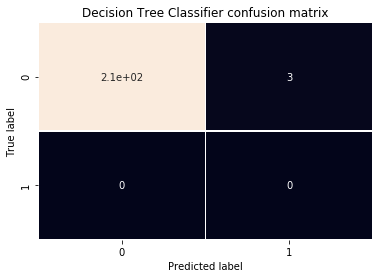

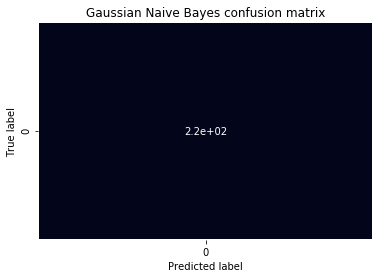

Test data- Gaussian Naive Bayes report 
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       216

   micro avg       1.00      1.00      1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



In [31]:
for item in unique_list:
    df_fin2['Type 1b'] = (df_fin2['Type 1'] == item).astype(bool)
    
    X=df_fin2.drop(['Type 1','Type 1b'], axis=1)
    Y=df_fin2['Type 1b']

    X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size = .3)

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)

    dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph
    
    features_list = X.columns.values
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(5,7))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title('Feature importances for: ' + item)
    plt.draw()
    plt.show()
    
    y_pred=clf.predict(X_test)
    print("Decision Tree Classifier report \n", classification_report(Y_test, y_pred))
    
    cfm=confusion_matrix(Y_test, y_pred)

    sns.heatmap(cfm, annot = True,  linewidths=.5, cbar =None)
    plt.title('Decision Tree Classifier confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    plt.show()
    clf_GNB = GaussianNB()
    clf_GNB = clf_GNB.fit(X_train, Y_train)
    
    y_pred_GNB=clf_GNB.predict(X_test)
    cfm=confusion_matrix(Y_test, y_pred_GNB)
    
    sns.heatmap(cfm, annot = True,  linewidths=.5, cbar =None)
    plt.title('Gaussian Naive Bayes confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print("Test data- Gaussian Naive Bayes report \n", classification_report(Y_test, y_pred_GNB))

So we repeat the process we did for the legendary pokemon with a for loop to do all the types in one go, and the results are fairly dismal. There is certainly some improvement than just randomly guessing, but not by much.

# More than 1 stat

A possible way forward is to keep appealing to the legendary case, but instead of using the total number of stats, use a variety of subtotals. For instance, we would add the attack and speed columns, then remove those two columns and attempt to train the on a fewer number of variables. This might improve things, but I don't think will be a work around for the linear algebra problem stated at the start.

# KNN ?

It is possible that K-nearest neighbors could work, but the prilimary graphing, and the dismal correlations above, do not make this look appealing. 